1. maybe run HMM or confidence interval to decide when regime changes and model fails. or add it into screener 
2. Build out screener
3. Make an options screener to screen for alerts and backtested profitability while remaining within regime. 
4. PCA and greeks to optimize features /done
5. Remove lag /done
6. Make the model a triple barrier: make it more robust in labeling / generating correct classes 
7. drop features when not predictive
8. weight trades by probability 
9. do a screener that tests prediction power with the hgb model
10. MAKE THE EXTREMA considerablyu higher / lower than surrounding values, cancel out noise.  
idea: take fidelity data and do a big KNN on options prices to discover timing, big orders, prices, roc, etc. 
also: break the bar data down by volume / dollar volume? 
also: add a few periods wait into backtest purchasing? 

Screener filter ideas: 
1. price * volume > 600M
2. roc over a period >0
3. SMA for period or moving rate of change positive trending 
4. low implied volatility 
5. good near expiry options volume 
6. near expiry decreasing volatility
Other ideas: HMM screener to detect consistent current option regime 
7. Make a gradient boost screener that can find stocks poised at low iv/hv with increasing volume/price/option feature for options trading, 

In [413]:
import pandas as pd 
import numpy as np 
import os
import pandas as pd

desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "datafix.csv")
datafix = pd.read_csv(desktop_path)


In [414]:
datafix = datafix.set_index("Date")


In [415]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# --- Black-Scholes Greeks calculation (without Rho) ---
def bs_greeks(S, K, T, r, sigma, option_type):
    # S: Stock price
    # K: Strike price
    # T: Time to expiry in years
    # r: Risk-free rate (set to 0.0 if unknown)
    # sigma: Implied volatility (as decimal, not percent)
    # option_type: 'call' or 'put'
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan, np.nan, np.nan, np.nan  # Handle invalid/missing data
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        delta = norm.cdf(d1)
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                 - r * K * np.exp(-r * T) * norm.cdf(d2))
    else:
        delta = norm.cdf(d1) - 1
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                 + r * K * np.exp(-r * T) * norm.cdf(-d2))
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return delta, gamma, vega, theta

# --- Apply to DataFrame ---
r = 0.0  # Risk-free rate, adjust if needed

def calc_row_greeks(row):
    S = row['stock price']
    K = row['strike']
    T = max(row['days_to_expiry'] / 365, 1e-6)  # Avoid division by zero
    sigma = row['IV']
    option_type = row['type'].lower()
    return bs_greeks(S, K, T, r, sigma, option_type)

greeks = datafix.apply(calc_row_greeks, axis=1, result_type='expand')
greeks.columns = ['delta', 'gamma', 'vega', 'theta']
datafix = pd.concat([datafix, greeks], axis=1)


In [416]:
import matplotlib.pyplot as plt
def plot(name):
    column_to_plot = name  # Replace with your actual column name

    if column_to_plot in datafix.columns:
     datafix[column_to_plot].plot(kind='line', title=f"{column_to_plot} Chart")
     plt.xlabel("Index")
     plt.ylabel(column_to_plot)
     plt.show()
    else:
        print(f"Column '{column_to_plot}' not found in datafix DataFrame.")


In [417]:
import numpy as np

# Standardize MACD_Hist using a rolling window (e.g., 50 periods)
window = 20
datafix["MACD_Hist_std"] = (
    (datafix["MACD_Hist"] - datafix["MACD_Hist"].rolling(window).mean()) /
    datafix["MACD_Hist"].rolling(window).std()
)



In [418]:
from arch import arch_model

# Drop NaN values from 'IV' for modeling
iv_series = datafix['IV'].dropna()

# Fit a GARCH(1,1) model to the IV series
model = arch_model(iv_series, mean='Zero', vol='GARCH', p=1, q=1)
model_fit = model.fit(disp='off')

# Get the conditional variance (volatility estimate) for each point
conditional_variance = model_fit.conditional_volatility

# Align the conditional volatility with the original dataframe's index
# This will fill NaN for rows where 'IV' was NaN
datafix['IV_garch_vol'] = conditional_variance.reindex(datafix.index)
datafix["GarchRoc"] = datafix['IV_garch_vol'].pct_change()
datafix["GarchRoc5sma"] = datafix["GarchRoc"].rolling(3).mean()
datafix["GarchSma"] = datafix['IV_garch_vol'].rolling(14).mean()
datafix["GarchSmaSpread"] = datafix['IV_garch_vol']-datafix["GarchSma"]

from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
spread_values = datafix['GarchSmaSpread'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler = StandardScaler()
standardized_spread = scaler.fit_transform(spread_values)

# Add the standardized spread back to the dataframe
datafix['GarchSmaSpread_std'] = standardized_spread
from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
garchroc5sma_values = datafix['GarchRoc5sma'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler_roc5sma = StandardScaler()
standardized_roc5sma = scaler_roc5sma.fit_transform(garchroc5sma_values)

# Add the standardized GarchRoc5sma back to the dataframe
datafix['GarchRocsma_std'] = standardized_roc5sma
from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
garchroc_values = datafix['GarchRoc'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler_garchroc = StandardScaler()
standardized_garchroc = scaler_garchroc.fit_transform(garchroc_values)

# Add the standardized GarchRoc back to the dataframe
datafix['GarchRoc_std'] = standardized_garchroc


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002646. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




In [419]:
import pandas as pd

def compute_rsi(df, column="Close", period=14):
    # Calculate price differences
    delta = df[column].diff()
    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    # Calculate exponential moving averages of gains and losses
    avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    # Calculate RS and RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    # Add RSI to dataframe
    df['RSI'] = rsi
    return df

compute_rsi(datafix)
# Calculate 14-period moving average of the 'Close' column
datafix['rsiMA_14'] = datafix['RSI'].rolling(window=14).mean()



In [420]:
datafix.tail(10)

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,...,IV_garch_vol,GarchRoc,GarchRoc5sma,GarchSma,GarchSmaSpread,GarchSmaSpread_std,GarchRocsma_std,GarchRoc_std,RSI,rsiMA_14
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-03 16:18:00,0.23,0.23,0.23,0.23,5,0.237842,-1.359852,-0.003758,-0.002870,-0.000888,...,0.165831,-0.000635,-0.003592,0.166864,-0.001033,-0.110313,-0.391160,-0.093372,43.377289,47.298378
2025-07-03 16:25:00,0.22,0.22,0.22,0.22,5,0.232634,-2.189701,-0.005198,-0.003336,-0.001863,...,0.165348,-0.002910,-0.003527,0.166945,-0.001597,-0.160024,-0.384827,-0.285451,39.965054,46.651334
2025-07-03 16:27:00,0.22,0.23,0.22,0.22,3,0.228562,-1.750368,-0.006268,-0.003922,-0.002346,...,0.164697,-0.003934,-0.002493,0.166942,-0.002245,-0.217141,-0.284579,-0.371857,39.965054,46.200459
2025-07-03 16:29:00,0.22,0.22,0.22,0.22,100,0.225403,-1.381884,-0.007034,-0.004544,-0.002490,...,0.164739,0.000255,-0.002197,0.166890,-0.002151,-0.208852,-0.255838,-0.018306,39.965054,45.749583
2025-07-03 16:31:00,0.22,0.22,0.22,0.22,23,0.222977,-1.076367,-0.007554,-0.005146,-0.002408,...,0.166167,0.008666,0.001662,0.166899,-0.000732,-0.083800,0.118287,0.691701,39.965054,45.500369
2025-07-03 16:36:00,0.22,0.22,0.22,0.22,5,0.221136,-0.825716,-0.007876,-0.005692,-0.002183,...,0.166715,0.003297,0.004073,0.166885,-0.000170,-0.034216,0.351983,0.238520,39.965054,45.251154
2025-07-03 16:42:00,0.24,0.24,0.24,0.24,1,0.225053,1.771500,-0.006442,-0.005842,-0.000600,...,0.165633,-0.006490,0.001825,0.166774,-0.001141,-0.119853,0.134032,-0.587559,51.107326,45.530925
2025-07-03 16:45:00,0.24,0.24,0.24,0.24,20,0.228221,1.407335,-0.005246,-0.005723,0.000477,...,0.164459,-0.007091,-0.003428,0.166505,-0.002046,-0.199612,-0.375191,-0.638305,51.107326,45.560099
2025-07-03 16:55:00,0.24,0.24,0.24,0.24,5,0.230776,1.119482,-0.004249,-0.005428,0.001179,...,0.164106,-0.002147,-0.005242,0.166163,-0.002058,-0.200632,-0.551120,-0.220977,51.107326,45.589272


In [421]:
#MACD IV
# Calculate MACD and Signal Line
def calculate_macd(df, close_col='IV_garch_vol', fast=12, slow=26, signal=9):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df['MACDvol'] = macd
    df['Signalvol'] = signal_line
    df['MACD_Histvol'] = macd_hist
    return df

macdata = calculate_macd(datafix, close_col='IV_garch_vol', fast=12, slow=26, signal=9)

# Plotting MACD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Split MACD histogram into positive and negative for color distinction
macd_hist = macdata['MACD_Histvol']
pos_hist = macd_hist.copy()
neg_hist = macd_hist.copy()
pos_hist[pos_hist < 0] = 0
neg_hist[neg_hist > 0] = 0

datafix['MACDROCvol'] = macdata['MACD_Histvol'].pct_change()

In [422]:
#MACD KALMAN
# Calculate MACD and Signal Line
def calculate_macd(df, close_col='Kalman', fast=12, slow=26, signal=9):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df['MACDkalman'] = macd
    df['Signalkalman'] = signal_line
    df['MACD_Histkalman'] = macd_hist
    return df

macdata = calculate_macd(datafix, close_col='Kalman', fast=12, slow=26, signal=9)

# Plotting MACD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Split MACD histogram into positive and negative for color distinction
macd_hist = macdata['MACD_Histkalman']
pos_hist = macd_hist.copy()
neg_hist = macd_hist.copy()
pos_hist[pos_hist < 0] = 0
neg_hist[neg_hist > 0] = 0
datafix['MACDROCkal'] = macdata['MACD_Histkalman'].pct_change()
datafix['MACDROC'] = macdata['MACD_Hist'].pct_change()
datafix['VolumeSMA9'] = datafix['Volume'].rolling(9).mean()
datafix['VolumeSMA26'] = datafix['Volume'].rolling(26).mean()

In [423]:
lag = 9 
# Precompute the rolling mean of Kalman_Roc (window=3)
datafix["Kalman_Roc_roll"] = datafix["Kalman_Roc"].rolling(lag).mean()
datafix["MACDROCvolroll9"] = datafix["MACDROCvol"].rolling(9).mean()
datafix["MACDROCkalroll9"] = datafix["MACDROCkal"].rolling(9).mean()

# assign other variables -- stocksma can be a screener filter along with volume and implied volatility 
datafix["stocktrend"] = datafix["stock price"].pct_change().rolling(3).mean()
datafix["sma30"] = datafix["Close"].rolling(20).mean()
datafix["smaspread"] = datafix["sma30"] - datafix["Close"] 

# no MACDs 
datafix["IV_garch_volsma"] = datafix['IV_garch_vol'].pct_change().rolling(18).mean()
datafix["kalmansma"] = datafix['Kalman'].pct_change().rolling(5).mean()

In [424]:
import numpy as np
from hmmlearn.hmm import GaussianHMM

# Calculate daily log returns from the 'Close' column
datafix['log_return'] = np.log(datafix['Close'] / datafix['Close'].shift(1))
returns = datafix['log_return'].dropna().values.reshape(-1, 1)

# Fit HMM (e.g., with 3 states)
model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=500, random_state=42)
model.fit(returns)

# Predict hidden states for each day
hidden_states = model.predict(returns)

# Add hidden states to your DataFrame (align index after dropna)
datafix = datafix.iloc[1:]  # because the first return is NaN
datafix['hmm_state'] = hidden_states


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_65161/2681209349.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [425]:
# Random forest settings 
buy_thresh = 0.4  # Threshold for buy signal(probability of rf outcome) df.2
sell_thresh = -0.4  # Threshold for sell signal(probability of rf outcome) df-.2
neighbors = 10
backtest_ma = 1 # Buy/sell moving average for rolling RF signal and backtest | keep same as stat window df20

/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_65161/3867433069.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Current regime: 1
Transition probabilities to next state: [0.02381876 0.97618124]
Forecasted next regime (most probable): 1


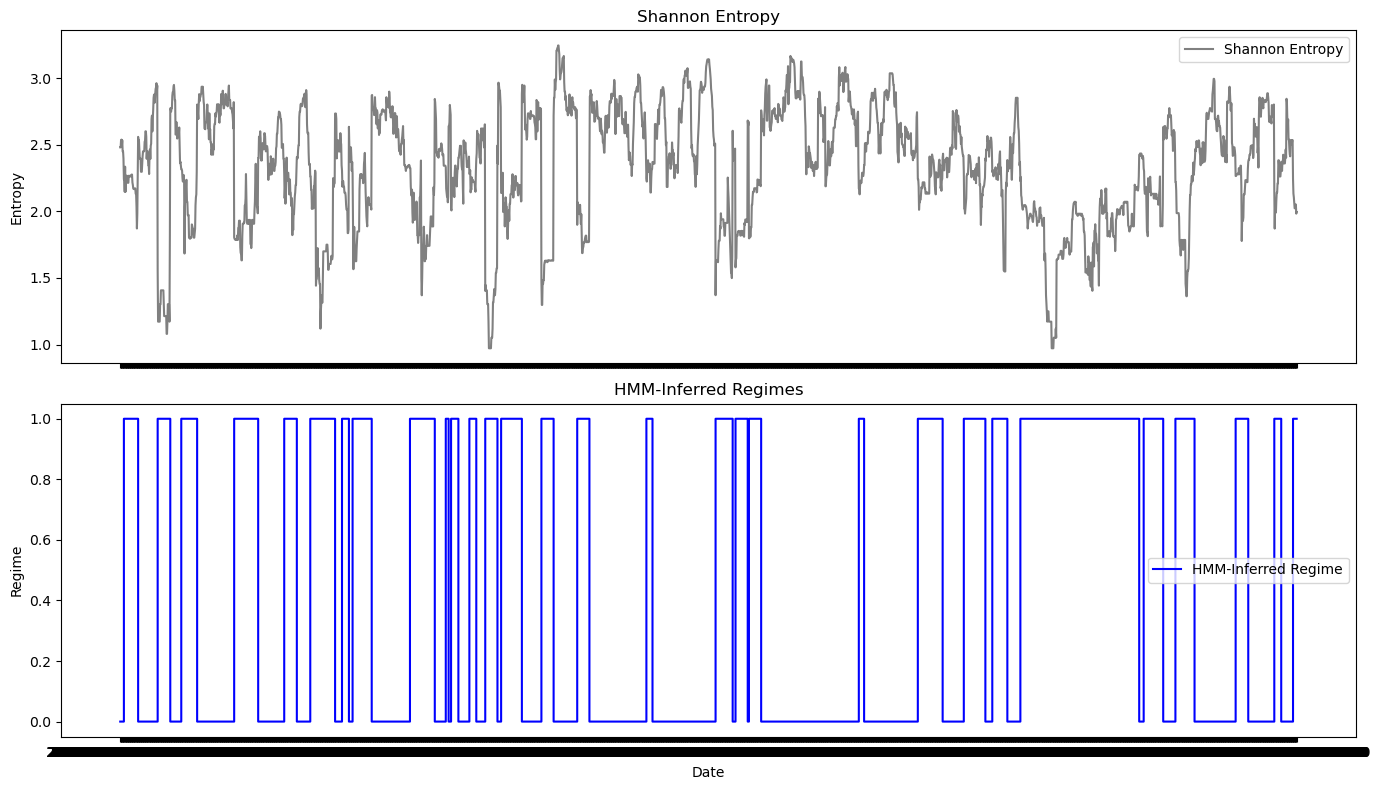

In [426]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from hmmlearn import hmm
import matplotlib.pyplot as plt

# --- 1. Calculate windowed Shannon entropy ---
def windowed_entropy(series, window_size=30, bins=10):
    entropies = []
    indices = []
    for i in range(len(series) - window_size + 1):
        window = series.iloc[i:i+window_size]
        hist, _ = np.histogram(window, bins=bins, density=True)
        hist = hist[hist > 0]  # Remove zero entries to avoid log(0)
        ent = entropy(hist, base=2)
        entropies.append(ent)
        indices.append(series.index[i + window_size - 1])
    return pd.Series(entropies, index=indices)

# Use your price data (assume datafix["Close"] is loaded)
data = datafix["Close"]

# Calculate log returns
returns = np.log(data / data.shift(1)).dropna()

# Calculate entropy series
entropy_series = windowed_entropy(returns, window_size=30, bins=10)

# --- 2. Fit HMM and infer regimes ---
X = entropy_series.values.reshape(-1, 1)
model = hmm.GaussianHMM(n_components=2, n_iter=100, random_state=42)
model.fit(X)
hidden_states = model.predict(X)

entropy_df = pd.DataFrame({
    'entropy': entropy_series,
    'regime': hidden_states
})
datafix["entropy"] = entropy_df['entropy']
# --- 3. Add lagged entropy features (example: 5 lags) ---
for lag in range(1, 6):
    entropy_df[f'entropy_lag{lag}'] = entropy_df['entropy'].shift(lag)
entropy_df = entropy_df.dropna()

# --- 4. Define and call the forecasting HMM function ---
def forecast_next_hmm_regime(hmm_model, entropy_df):
    """
    Forecast the most probable next regime using the last inferred regime and the transition matrix.
    """
    current_regime = int(entropy_df['regime'].iloc[-1])
    transmat = hmm_model.transmat_
    next_state_probs = transmat[current_regime]
    forecasted_next_regime = np.argmax(next_state_probs)
    return current_regime, next_state_probs, forecasted_next_regime

# Call the function
current_regime, next_state_probs, forecasted_next_regime = forecast_next_hmm_regime(model, entropy_df)

print(f"Current regime: {current_regime}")
print(f"Transition probabilities to next state: {next_state_probs}")
print(f"Forecasted next regime (most probable): {forecasted_next_regime}")

# (Optional) Store the forecast in the DataFrame for reference
entropy_df['forecasted_next_regime'] = np.nan
entropy_df.at[entropy_df.index[-1], 'forecasted_next_regime'] = forecasted_next_regime

# --- 5. (Optional) Plot entropy and regimes ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
ax1.plot(entropy_df.index, entropy_df['entropy'], color='gray', label='Shannon Entropy')
ax1.set_title('Shannon Entropy')
ax1.set_ylabel('Entropy')
ax1.legend()

ax2.plot(entropy_df.index, entropy_df['regime'], color='blue', label='HMM-Inferred Regime', drawstyle='steps-post')
ax2.set_title('HMM-Inferred Regimes')
ax2.set_ylabel('Regime')
ax2.set_xlabel('Date')
ax2.legend()

plt.tight_layout()
plt.show()
import numpy as np
import pandas as pd

# Align Close prices with entropy_df index
entropy_df['Close'] = datafix['Close'].reindex(entropy_df.index)

# Drop rows with missing Close or regime
entropy_df = entropy_df.dropna(subset=['Close', 'regime'])

# Create lagged features for Close price (past 5 days)
for lag in range(1, 6):
    entropy_df[f'Close_lag{lag}'] = entropy_df['Close'].shift(lag)

# Drop rows with missing lagged features
entropy_df = entropy_df.dropna(subset=[f'Close_lag{lag}' for lag in range(1, 6)])

# Now entropy_df is ready for regime-wise modeling


In [427]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report

# --- Local extrema detection (as labels, not features) ---
series = datafix['Kalman'].values
order = neighbors  # Adjust for sensitivity

max_idx = argrelextrema(series, np.greater, order=order)[0]
min_idx = argrelextrema(series, np.less, order=order)[0]

datafix['BuyLabel'] = 0
datafix['SellLabel'] = 0
datafix.iloc[min_idx, datafix.columns.get_loc('BuyLabel')] = 1
datafix.iloc[max_idx, datafix.columns.get_loc('SellLabel')] = 1

# --- Feature engineering ---
datafix["VolumeSMA3"] = datafix["Volume"].rolling(3).mean()
datafix["VolumeSMA9"] = datafix["Volume"].rolling(9).mean()
datafix["VolumeSMA26"] = datafix["Volume"].rolling(26).mean()

# --- Forecasted regime feature ---
# Assume you have already fit an HMM called `model` and assigned 'hmm_state' column
# model.transmat_ is the transition matrix, datafix['hmm_state'] is the current regime

def forecast_next_regime(states, transmat):
    # Returns the most probable next regime for each row based on the current regime
    return [np.argmax(transmat[state]) if not np.isnan(state) else np.nan for state in states]

datafix['forecasted_hmm_state'] = forecast_next_regime(datafix['hmm_state'].values, model.transmat_)

# --- Define features (add forecasted regime) ---
features = [
    "kalmansma",
    "IV_garch_vol",
    "VolumeSMA9",
    "Close",
    "stock price", 
    "MACD_Hist",
    "Kalman_Roc",
    "delta",
    "gamma",
    "vega",
    "theta",
    "forecasted_hmm_state",
    "Volume", 
    "RSI",
]

# Drop rows with missing values in features or label for training
model_data = datafix.dropna(subset=features + ["BuyLabel"])

# Prepare a column for storing predictions
model_data["Predicted_Signal"] = np.nan

# Use the forecasted regime as a feature for the whole dataset (no regime split)
X = model_data[features]
y = model_data["BuyLabel"]

# 70/30 split, no shuffle to preserve time order
split_idx = int(len(X) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Train model
hgb = HistGradientBoostingClassifier(
    max_iter=1000,
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
    class_weight='balanced',
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)

hgb.fit(X_train, y_train)

# Predict for the entire dataset
model_data["Predicted_Signal"] = hgb.predict(X)

# Optionally, print classification report for test set
y_pred_test = hgb.predict(X_test)
print("\nClassification report (using forecasted regime as feature):")
print(classification_report(y_test, y_pred_test))

# Merge predictions back into your main datafix DataFrame
datafix["Predicted_Signal"] = model_data["Predicted_Signal"]



Classification report (using forecasted regime as feature):
              precision    recall  f1-score   support

           0       0.99      0.77      0.87       854
           1       0.07      0.67      0.12        21

    accuracy                           0.77       875
   macro avg       0.53      0.72      0.49       875
weighted avg       0.97      0.77      0.85       875



/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_65161/1676346765.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_65161/1676346765.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_65161/1676346765.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [428]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report

# --- Local maxima detection for SellLabel ---
order = neighbors  # Sensitivity parameter
series = datafix['Kalman'].values
max_idx = argrelextrema(series, np.greater, order=order)[0]

datafix['SellLabel'] = 0
datafix.iloc[max_idx, datafix.columns.get_loc('SellLabel')] = 1

# --- Feature engineering ---
datafix["VolumeSMA3"] = datafix["Volume"].rolling(3).mean()
datafix["VolumeSMA9"] = datafix["Volume"].rolling(9).mean()
datafix["VolumeSMA26"] = datafix["Volume"].rolling(26).mean()

# --- Forecasted regime feature ---
# Assume you have already fit an HMM called `model` and assigned 'hmm_state' column
def forecast_next_regime(states, transmat):
    # Returns the most probable next regime for each row based on the current regime
    return [np.argmax(transmat[state]) if not np.isnan(state) else np.nan for state in states]

datafix['forecasted_hmm_state'] = forecast_next_regime(datafix['hmm_state'].values, model.transmat_)



# Drop rows with missing values in features or SellLabel for training
model_data = datafix.dropna(subset=features + ["SellLabel"])

# Prepare a column to store predictions
model_data["Predicted_Sell"] = np.nan

# Use the forecasted regime as a feature for the whole dataset (no regime split)
X = model_data[features]
y = model_data["SellLabel"]

# 70/30 split, no shuffle to preserve time order
split_idx = int(len(X) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Train model
hgb_sell = HistGradientBoostingClassifier(
    max_iter=1000,
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
    class_weight='balanced',
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)
hgb_sell.fit(X_train, y_train)

# Predict for the entire dataset
model_data["Predicted_Sell"] = hgb_sell.predict(X)

# Optionally, print classification report for test set
y_pred_test = hgb_sell.predict(X_test)
print("\nClassification report (using forecasted regime as feature):")
print(classification_report(y_test, y_pred_test))

# Merge predictions back into your main datafix DataFrame
datafix["Predicted_Sell"] = model_data["Predicted_Sell"]


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_65161/3141736453.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_65161/3141736453.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_65161/3141736453.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th


Classification report (using forecasted regime as feature):
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       856
           1       0.06      0.21      0.10        19

    accuracy                           0.92       875
   macro avg       0.52      0.57      0.53       875
weighted avg       0.96      0.92      0.94       875



/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_65161/3141736453.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_65161/3141736453.py:67: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [429]:
# Get probabilities (assuming binary classification, class 1 is buy/sell)
datafix["Buy_Prob"] = hgb.predict_proba(datafix[features])[:, 1]
datafix["Sell_Prob"] = hgb_sell.predict_proba(datafix[features])[:, 1]

# Weighted difference (you can adjust the weights)
datafix["Combined_Score"] = datafix["Buy_Prob"] - datafix["Sell_Prob"]

# Define thresholds for action
def weighted_signal(score, buy_thresh=buy_thresh, sell_thresh=sell_thresh):
    if score > buy_thresh:
        return "buy"
    elif score < sell_thresh:
        return "sell"
    else:
        return "hold"

datafix["Combined_Signal"] = datafix["Combined_Score"].apply(weighted_signal)


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_65161/223477919.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_65161/223477919.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_65161/223477919.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [430]:
import plotly.graph_objects as go

fig = go.Figure()

# Plot the close price
fig.add_trace(go.Scatter(
    x=datafix.index, y=datafix["Close"],
    mode='lines', name='Close', line=dict(color='black', width=2)
))

# Plot combined buy signals (green upward triangle)
buy_signals = datafix[datafix["Combined_Signal"] == "buy"]
fig.add_trace(go.Scatter(
    x=buy_signals.index, y=buy_signals["Close"],
    mode='markers', name='Combined Buy',
    marker=dict(symbol='triangle-up', color='green', size=14, line=dict(color='black', width=1.5))
))

# Plot combined sell signals (red downward triangle)
sell_signals = datafix[datafix["Combined_Signal"] == "sell"]
fig.add_trace(go.Scatter(
    x=sell_signals.index, y=sell_signals["Close"],
    mode='markers', name='Combined Sell',
    marker=dict(symbol='triangle-down', color='red', size=14, line=dict(color='black', width=1.5))
))

# Draw prediction start line
split_idx_bar = int(len(datafix) * 0.7)
split_date_bar = datafix.index[split_idx_bar]
fig.add_vline(x=split_date_bar, line=dict(color='black', dash='dash', width=2))


# Layout settings
fig.update_layout(
    title="Close Price with Combined Buy/Sell Signals",
    xaxis_title="Date",
    yaxis_title="Close Price",
    legend=dict(x=0.01, y=0.99),
    hovermode='x unified',
    template='plotly_white',
    width=1000,
    height=500
)

fig.show()



/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_65161/3149753067.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_65161/3149753067.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



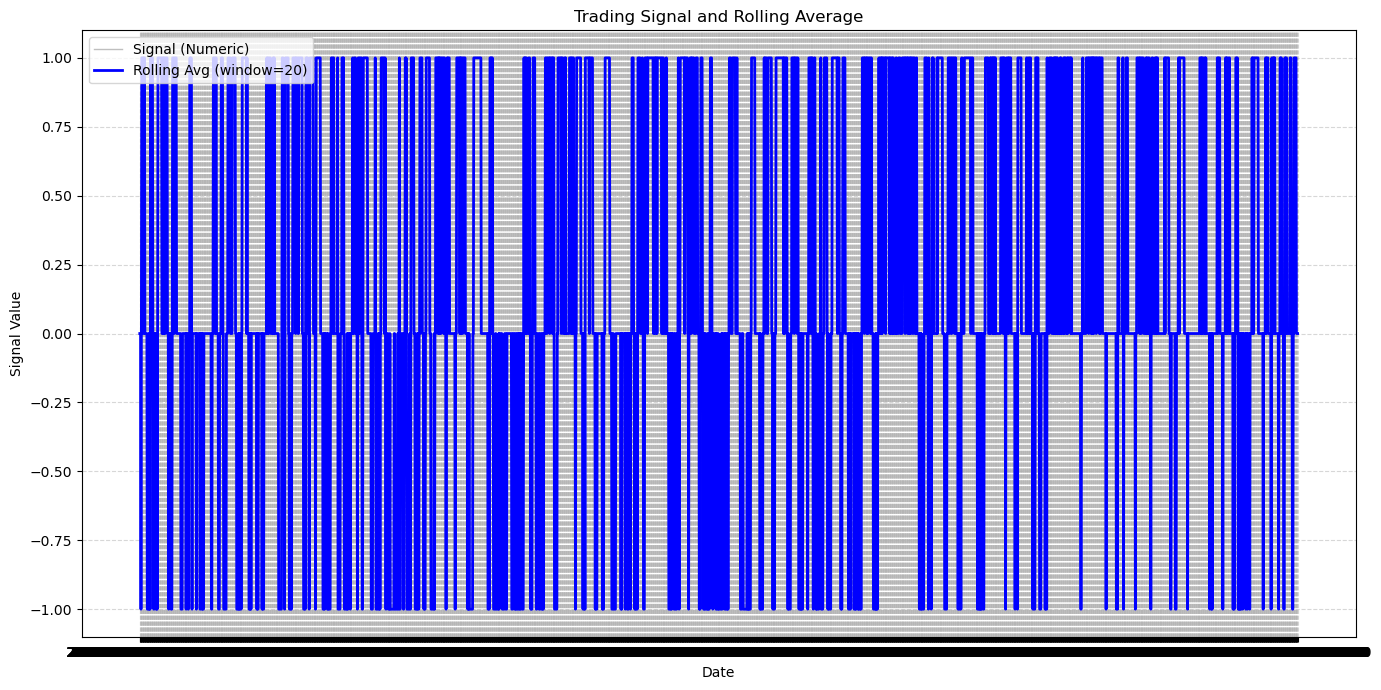

In [431]:
# Map signals to numeric: buy=1, sell=-1, hold=0 (example)
signal_map = {"buy": 1, "sell": -1, "hold": 0}
datafix["Signal_Num"] = datafix["Combined_Signal"].map(signal_map)

# Rolling average
datafix["Rolling_Signal_Num"] = datafix["Signal_Num"].rolling(window=backtest_ma, center=False).mean()

# Plot similarly as above
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 7))

# Plot the numeric signal (buy=1, sell=-1, hold=0)
plt.plot(datafix.index, datafix["Signal_Num"], label="Signal (Numeric)", color="gray", alpha=0.5, linewidth=1)

# Plot the rolling average of the signal
plt.plot(
    datafix.index,
    datafix["Rolling_Signal_Num"],
    label=f"Rolling Avg (window={20})",
    color="blue",
    linewidth=2
)

plt.title("Trading Signal and Rolling Average")
plt.xlabel("Date")
plt.ylabel("Signal Value")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


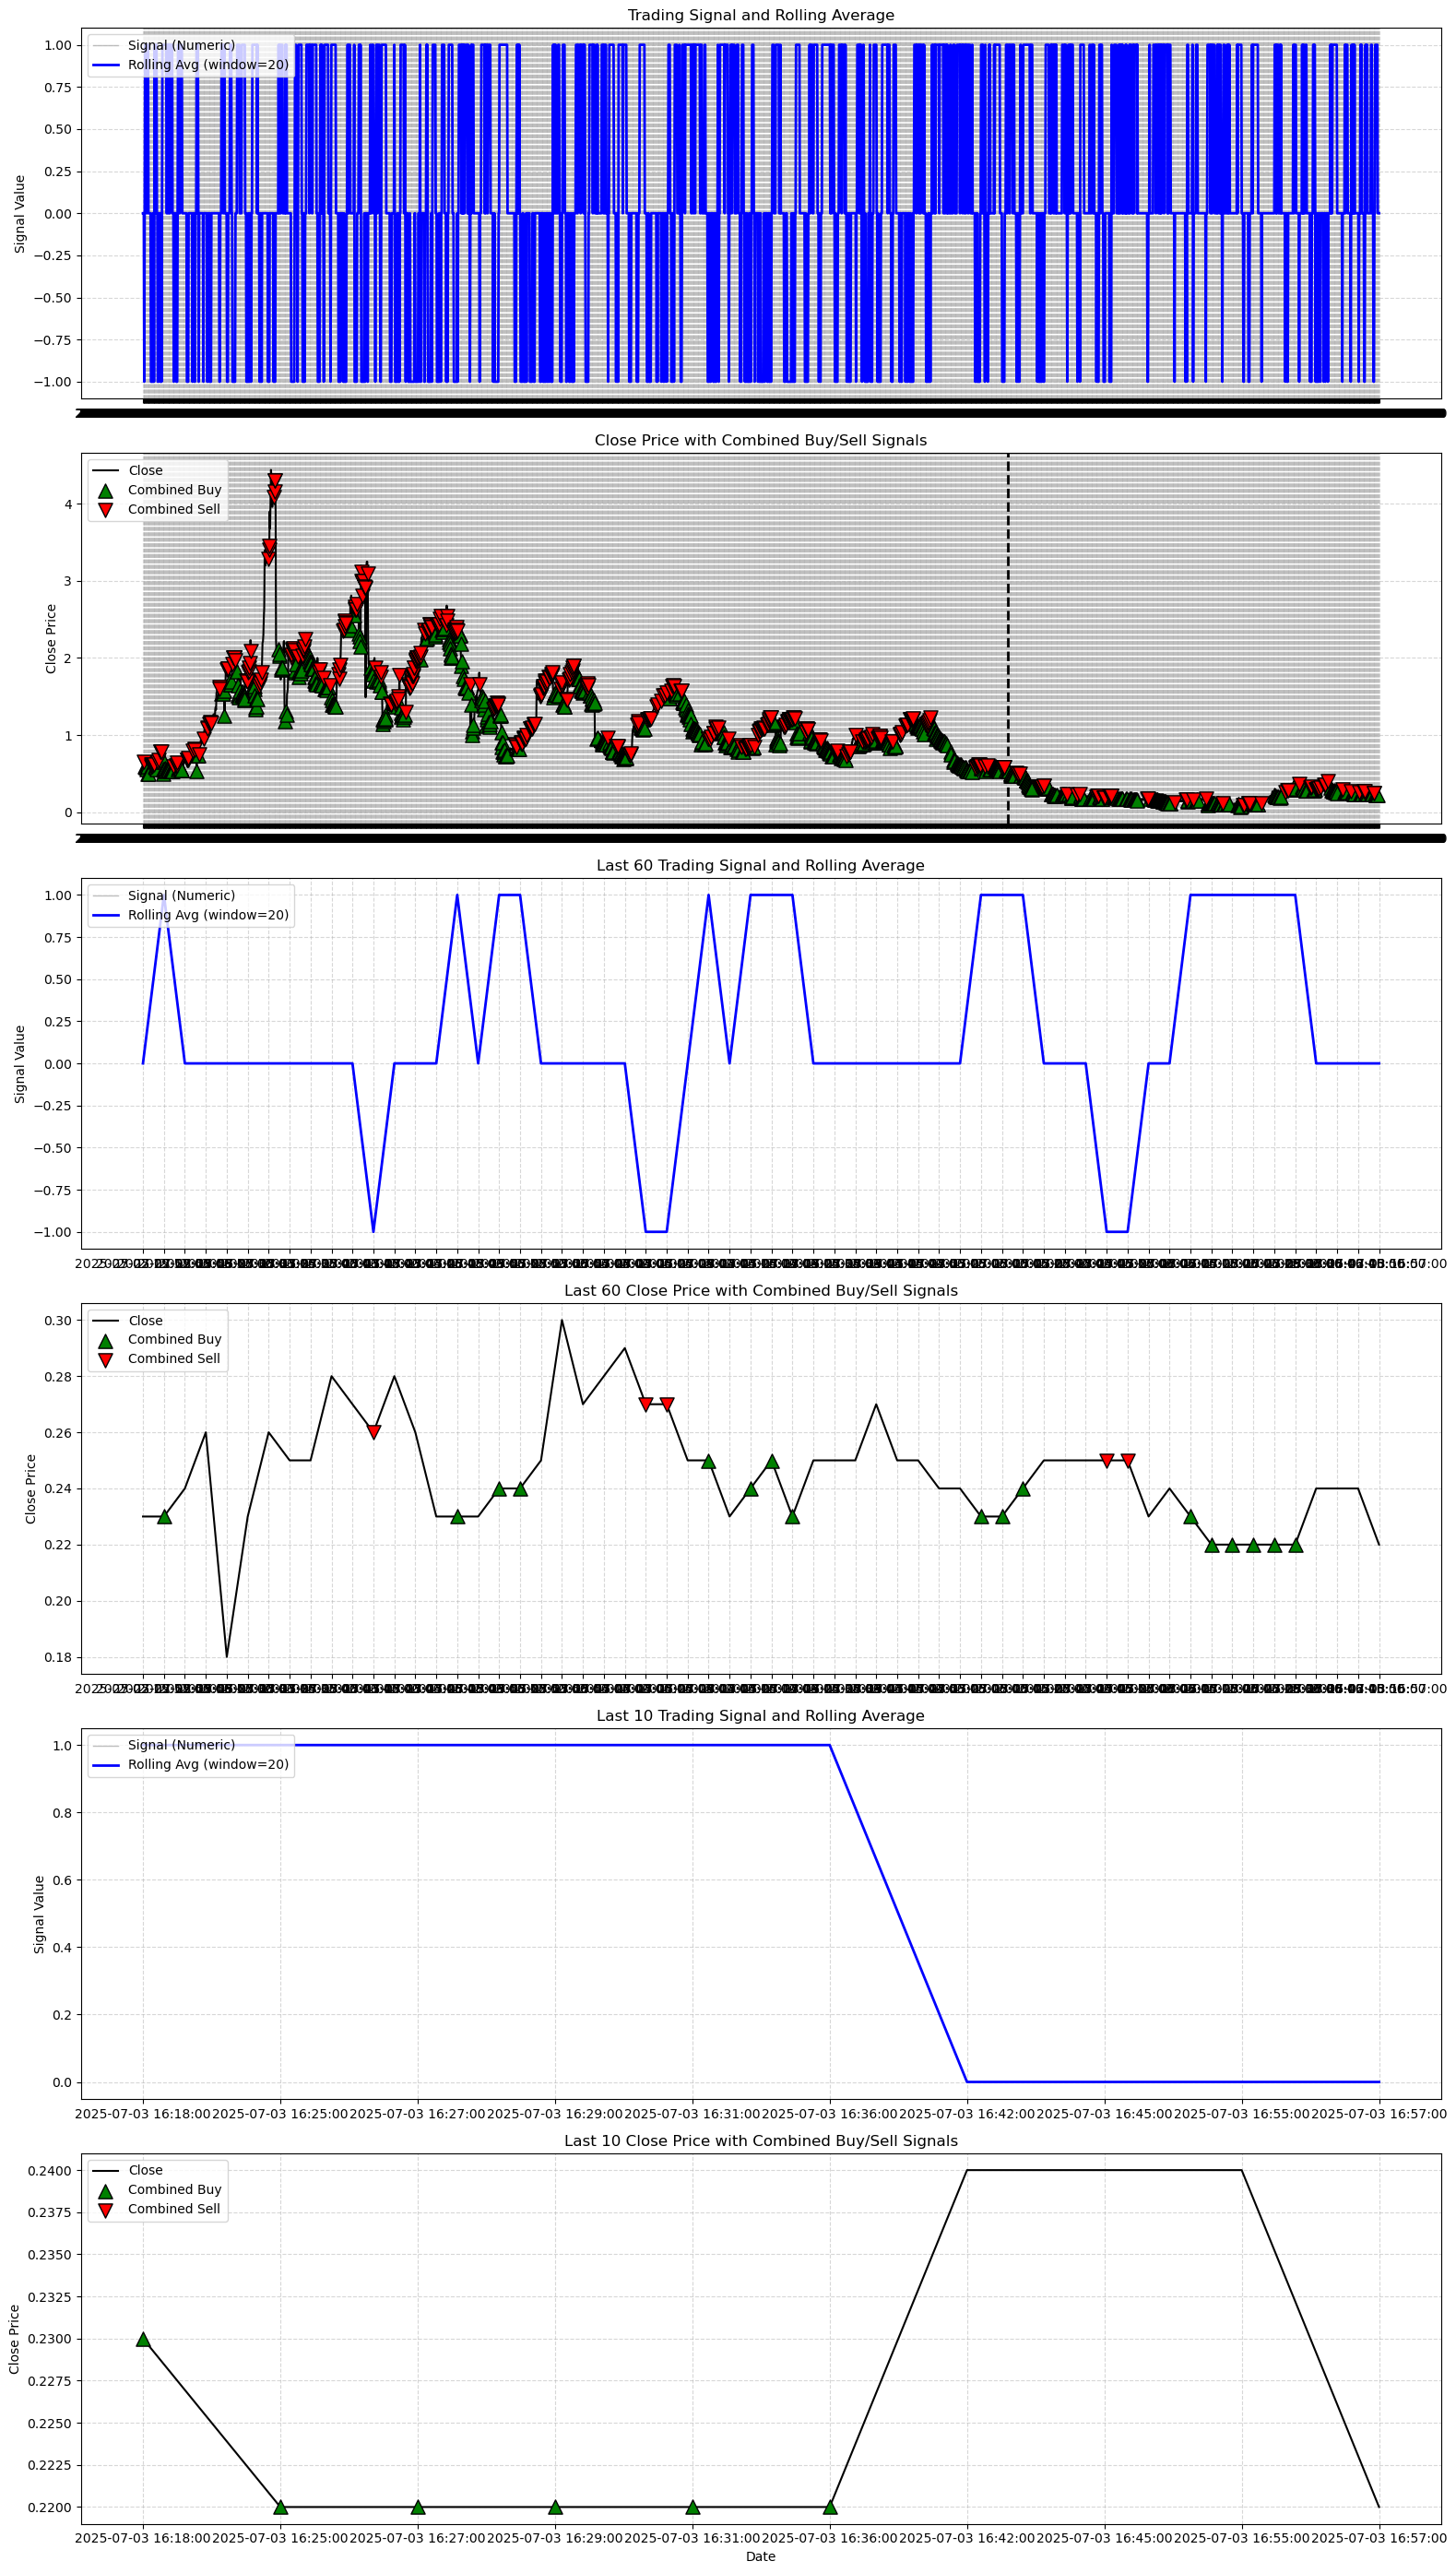

In [432]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 1, figsize=(16, 28), sharex=False, sharey=False)

# --- Full range charts (first two) ---
axes[0].plot(datafix.index, datafix["Signal_Num"], label="Signal (Numeric)", color="gray", alpha=0.5, linewidth=1)
axes[0].plot(datafix.index, datafix["Rolling_Signal_Num"], label="Rolling Avg (window=20)", color="blue", linewidth=2)
axes[0].set_ylabel("Signal Value")
axes[0].set_title("Trading Signal and Rolling Average")
axes[0].legend(loc="upper left")
axes[0].grid(True, linestyle='--', alpha=0.5)

axes[1].plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)
buy_signals = datafix[datafix["Combined_Signal"] == "buy"]
axes[1].scatter(buy_signals.index, buy_signals["Close"], marker="^", color="green", edgecolor="black", s=120, label="Combined Buy", zorder=3)
sell_signals = datafix[datafix["Combined_Signal"] == "sell"]
axes[1].scatter(sell_signals.index, sell_signals["Close"], marker="v", color="red", edgecolor="black", s=120, label="Combined Sell", zorder=3)
axes[1].set_ylabel("Close Price")
axes[1].set_title("Close Price with Combined Buy/Sell Signals")
axes[1].legend(loc="upper left")
axes[1].grid(True, linestyle='--', alpha=0.5)
split_idx_bar = int(len(datafix) * 0.7)
split_date_bar = datafix.index[split_idx_bar]
axes[1].axvline(x=split_date_bar, color='black', linestyle='--', linewidth=2, label='Prediction Start')

# --- Last 60 datapoints charts (independent axes) ---
last60 = datafix.tail(60)
axes[2].plot(last60.index, last60["Signal_Num"], label="Signal (Numeric)", color="gray", alpha=0.5, linewidth=1)
axes[2].plot(last60.index, last60["Rolling_Signal_Num"], label="Rolling Avg (window=20)", color="blue", linewidth=2)
axes[2].set_ylabel("Signal Value")
axes[2].set_title("Last 60 Trading Signal and Rolling Average")
axes[2].legend(loc="upper left")
axes[2].grid(True, linestyle='--', alpha=0.5)

axes[3].plot(last60.index, last60["Close"], label="Close", color="black", linewidth=1.5)
buy_signals_last60 = last60[last60["Combined_Signal"] == "buy"]
axes[3].scatter(buy_signals_last60.index, buy_signals_last60["Close"], marker="^", color="green", edgecolor="black", s=120, label="Combined Buy", zorder=3)
sell_signals_last60 = last60[last60["Combined_Signal"] == "sell"]
axes[3].scatter(sell_signals_last60.index, sell_signals_last60["Close"], marker="v", color="red", edgecolor="black", s=120, label="Combined Sell", zorder=3)
axes[3].set_ylabel("Close Price")
axes[3].set_title("Last 60 Close Price with Combined Buy/Sell Signals")
axes[3].legend(loc="upper left")
axes[3].grid(True, linestyle='--', alpha=0.5)

# --- Last 10 datapoints charts (independent axes) ---
last10 = datafix.tail(10)
axes[4].plot(last10.index, last10["Signal_Num"], label="Signal (Numeric)", color="gray", alpha=0.5, linewidth=1)
axes[4].plot(last10.index, last10["Rolling_Signal_Num"], label="Rolling Avg (window=20)", color="blue", linewidth=2)
axes[4].set_ylabel("Signal Value")
axes[4].set_title("Last 10 Trading Signal and Rolling Average")
axes[4].legend(loc="upper left")
axes[4].grid(True, linestyle='--', alpha=0.5)

axes[5].plot(last10.index, last10["Close"], label="Close", color="black", linewidth=1.5)
buy_signals_last10 = last10[last10["Combined_Signal"] == "buy"]
axes[5].scatter(buy_signals_last10.index, buy_signals_last10["Close"], marker="^", color="green", edgecolor="black", s=120, label="Combined Buy", zorder=3)
sell_signals_last10 = last10[last10["Combined_Signal"] == "sell"]
axes[5].scatter(sell_signals_last10.index, sell_signals_last10["Close"], marker="v", color="red", edgecolor="black", s=120, label="Combined Sell", zorder=3)
axes[5].set_ylabel("Close Price")
axes[5].set_title("Last 10 Close Price with Combined Buy/Sell Signals")
axes[5].legend(loc="upper left")
axes[5].grid(True, linestyle='--', alpha=0.5)

plt.xlabel("Date")
plt.tight_layout()
plt.show()


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_65161/1960438165.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



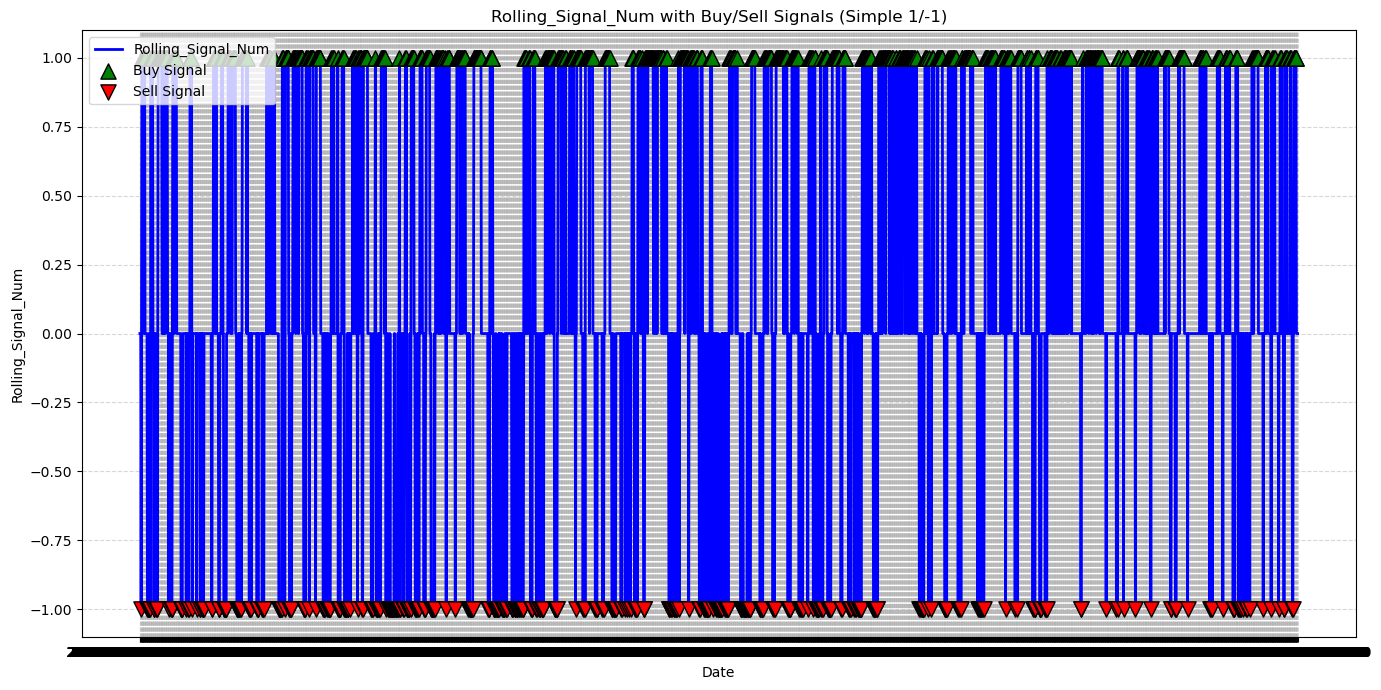

In [433]:
import numpy as np
import pandas as pd

# Example buy/sell logic: 
# Buy when Rolling_Signal_Num > 0, Sell when Rolling_Signal_Num < 0

datafix['Trade_Signal'] = 0
datafix.loc[datafix['Rolling_Signal_Num'] > 0, 'Trade_Signal'] = 1
datafix.loc[datafix['Rolling_Signal_Num'] < 0, 'Trade_Signal'] = -1

# ---- Plotting (unchanged) ----
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(datafix.index, datafix["Rolling_Signal_Num"], label="Rolling_Signal_Num", color="blue", linewidth=2)
buy_signals = datafix[datafix['Trade_Signal'] == 1]
plt.scatter(
    buy_signals.index,
    buy_signals["Rolling_Signal_Num"],
    marker="^",
    color="green",
    edgecolor="black",
    s=120,
    label="Buy Signal",
    zorder=3
)
sell_signals = datafix[datafix['Trade_Signal'] == -1]
plt.scatter(
    sell_signals.index,
    sell_signals["Rolling_Signal_Num"],
    marker="v",
    color="red",
    edgecolor="black",
    s=120,
    label="Sell Signal",
    zorder=3
)
plt.title("Rolling_Signal_Num with Buy/Sell Signals (Simple 1/-1)")
plt.xlabel("Date")
plt.ylabel("Rolling_Signal_Num")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Total Return (Last 40%): -79.53%


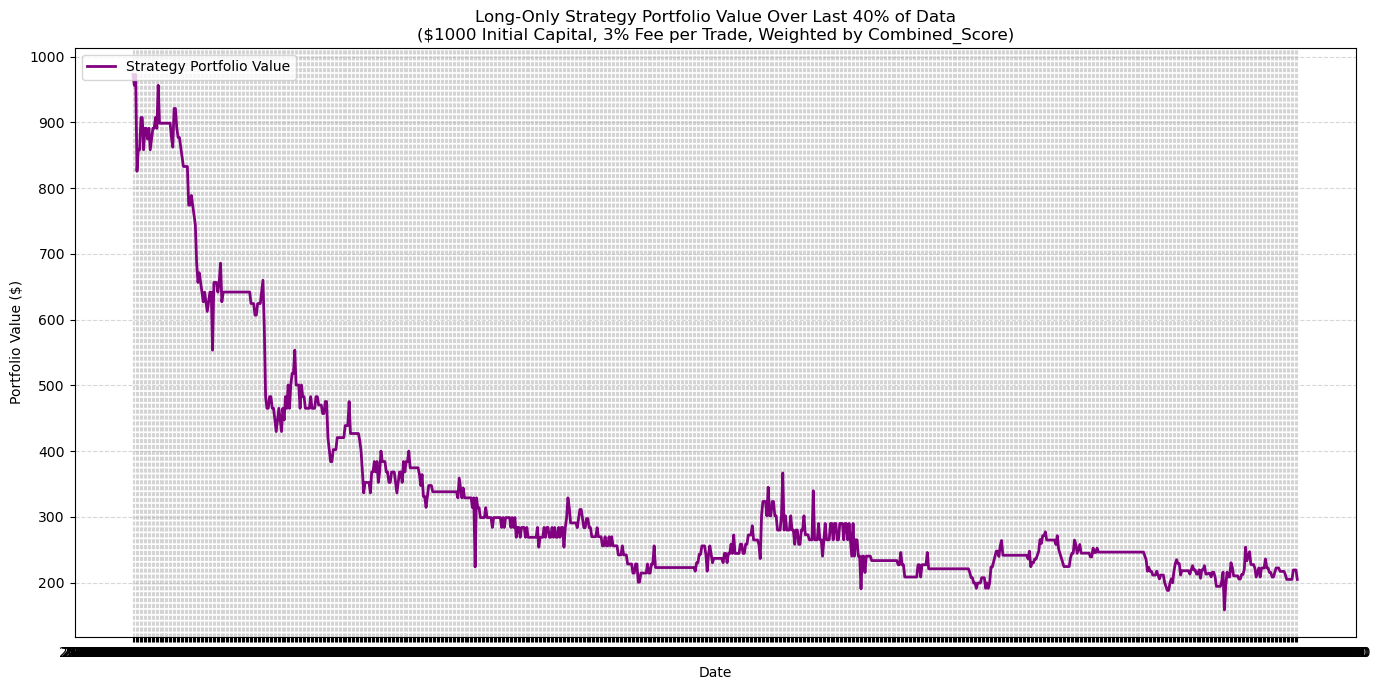


Selected columns from the last 30% of data:
                     Close  Combined_Score Combined_Signal
Date                                                      
2025-07-03 16:18:00   0.23        0.777033             buy
2025-07-03 16:25:00   0.22        0.777033             buy
2025-07-03 16:27:00   0.22        0.777033             buy
2025-07-03 16:29:00   0.22        0.777033             buy
2025-07-03 16:31:00   0.22        0.861081             buy
2025-07-03 16:36:00   0.22        0.861081             buy
2025-07-03 16:42:00   0.24        0.529994            hold
2025-07-03 16:45:00   0.24        0.513486            hold
2025-07-03 16:55:00   0.24        0.233976            hold
2025-07-03 16:57:00   0.22        0.527498            hold


In [434]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Slice the last 30% of the data ---
start_idx = int(len(datafix) * 0.7)
datafix_last40 = datafix.iloc[start_idx:].copy()

# --- 2. Normalize Combined_Score to [0, 1] if needed ---
if datafix_last40['Combined_Score'].max() > 1 or datafix_last40['Combined_Score'].min() < 0:
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    datafix_last40['Combined_Score'] = scaler.fit_transform(datafix_last40[['Combined_Score']])

# --- 3. Initialize variables ---
initial_capital = 1000
capital = initial_capital
position = 0  # 1 for long, 0 for flat
positions = []
portfolio = []
entry_price = None
fee_rate = 0.03  # 3% trading fee
allocation = 0   # Fraction of capital allocated to position

# --- 4. Backtest loop with weighted allocation ---
for idx, row in datafix_last40.iterrows():
    signal = row['Trade_Signal']
    price = row['Close']
    score = row['Combined_Score']

    # Enter trade: allocate capital based on Combined_Score
    if signal == 1 and position == 0:
        allocation = score
        position = 1
        entry_price = price
        capital = capital * (1 - allocation * fee_rate)  # Apply entry fee only to allocated capital

    # Exit trade: deallocate, apply exit fee
    elif signal == -1 and position == 1:
        position = 0
        # Only allocated capital participates in trade
        capital = capital * (1 - allocation) + capital * allocation * (price / entry_price) * (1 - fee_rate)
        entry_price = None
        allocation = 0

    # Portfolio value: unallocated cash + value of current position
    if position == 1:
        portfolio_value = capital * (1 - allocation) + capital * allocation * (price / entry_price)
    else:
        portfolio_value = capital

    portfolio.append(portfolio_value)
    positions.append(position)

# --- 5. Attach results ---
datafix_last40['Position'] = positions
datafix_last40['Portfolio'] = portfolio

# --- 6. Calculate total return ---
total_return = (datafix_last40['Portfolio'].iloc[-1] - initial_capital) / initial_capital * 100
print(f"Total Return (Last 40%): {total_return:.2f}%")

# --- 7. Plot ---
plt.figure(figsize=(14, 7))
plt.plot(datafix_last40.index, datafix_last40['Portfolio'], label='Strategy Portfolio Value', color='purple', linewidth=2)
plt.title('Long-Only Strategy Portfolio Value Over Last 40% of Data\n($1000 Initial Capital, 3% Fee per Trade, Weighted by Combined_Score)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 8. Create and show the selected DataFrame ---
# (Assumes you have a 'Combined_Signal' column in your data)
df_selected_last40 = datafix_last40.loc[:, ['Close', 'Combined_Score', 'Combined_Signal']]
print("\nSelected columns from the last 30% of data:")
print(df_selected_last40.tail(10))


In [435]:
# --- 9. Trade statistics ---

num_trades = 0
num_wins = 0
total_fees = 0
allocations = []
trade_returns = []

in_trade = False
entry_price = None
entry_capital = None
entry_allocation = None

for idx, row in datafix_last40.iterrows():
    signal = row['Trade_Signal']
    price = row['Close']
    score = row['Combined_Score']
    # Enter trade
    if signal == 1 and not in_trade:
        in_trade = True
        entry_price = price
        entry_capital = capital
        entry_allocation = score
        total_fees += entry_capital * entry_allocation * fee_rate
        allocations.append(entry_allocation)
        num_trades += 1
    # Exit trade
    elif signal == -1 and in_trade:
        in_trade = False
        exit_price = price
        # Only allocated capital participates in trade
        gross_return = (exit_price / entry_price) - 1
        trade_return = gross_return * entry_allocation
        trade_returns.append(trade_return)
        # Fee on exit
        total_fees += entry_capital * entry_allocation * fee_rate
        # Win if trade return > 0
        if gross_return > 0:
            num_wins += 1

# Avoid division by zero
win_rate = (num_wins / num_trades) * 100 if num_trades > 0 else 0
avg_allocation = np.mean(allocations) if allocations else 0

print(f"Number of trades: {num_trades}")
print(f"Total fees paid: ${total_fees:.2f}")
print(f"Win rate (profitable trades): {win_rate:.2f}%")
print(f"Average allocation per trade: {avg_allocation:.2f}")


Number of trades: 23
Total fees paid: $242.26
Win rate (profitable trades): 39.13%
Average allocation per trade: 0.85
